In [1]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN/Revision') # change folder name


Mounted at /content/drive


#### Setup of the Environment

In [2]:
#!pip install --upgrade plotly
!pip install -q -U keras-tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.1 MB/s eta 0:00:00


# New Section

In [3]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import keras_tuner as kt #hyperparameter tuning
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *
from functions.model import *


#### Experiment

##### Setting up experiment parameters

In [4]:
#Experimental parameters
prediction = 'Outcome' 
experiment =  'AG' #'AG_LS' #'AG','MS', 'IX'
timelapsed = 'total'


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/Revision/BPIC17"
MILESTONE_DIR = MY_WORKSPACE_DIR+'/'+experiment+'/'

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2017_OUTCOME.csv')
log_name = 'BPIC_2017'


#saving parameters to a dictionary
args = get_parameters(MILESTONE_DIR, MY_WORKSPACE_DIR, prediction, experiment, file_name, log_name,None)



In [5]:
#Load data

log_df = pd.read_csv(args['file_name'])
log_df = log_df.reset_index(drop=True)
log_df = log_df.rename(columns = {'MILESTONE':'ACTIVITY'})
log_df.head()

,CASEID,ACTIVITY,next_activity,ACTIVITY_INDEX,RESOURCE,START_TIMESTAMP,COMPLETE_TIMESTAMP,TIME_ELAPSED,TASK_DURATION,CREDIT_SCORE,APP_TYPE,AMT_REQ,TERMS,OUTCOME
0,Application_102241622,O_Sent (mail and online),O_Created,7,User_53,2016-06-09 20:27:08.7510000,2016-06-09 20:29:30.3180000,38,0,0,New credit,5000.0,138,O_Accepted
1,Application_102241622,W_Complete application,O_Sent (mail and online),8,User_53,2016-06-09 20:29:30.3180000,2016-06-09 20:29:30.3870000,38,0,0,New credit,5000.0,138,O_Accepted
2,Application_102241622,A_Complete,W_Complete application,9,User_53,2016-06-09 20:29:30.3870000,2016-06-09 20:29:30.4310000,38,0,0,New credit,5000.0,138,O_Accepted
3,Application_102241622,O_Create Offer,A_Complete,10,User_5,2016-06-09 20:29:30.4310000,2016-07-07 20:02:08.4290000,38,672,1,New credit,5000.0,138,O_Accepted
4,Application_102241622,O_Created,O_Create Offer,11,User_5,2016-07-07 20:02:08.4290000,2016-07-07 20:02:10.0020000,710,0,0,New credit,5000.0,138,O_Accepted


In [6]:
#feature categories
cat_dynamic = ['ACTIVITY','RESOURCE']
num_dynamic = ['TASK_DURATION','TIME_ELAPSED','CREDIT_SCORE'] 
cat_static = ['APP_TYPE'] 
num_static = ['AMT_REQ','TERMS']
activity_name = 'ACTIVITY'

##### Data Preprocessing

In [7]:


for feat in cat_dynamic:
  log_df[feat] = log_df[feat].astype('category')
for feat in cat_static:
  log_df[feat] = log_df[feat].astype('category')


log_df.head()

,CASEID,ACTIVITY,next_activity,ACTIVITY_INDEX,RESOURCE,START_TIMESTAMP,COMPLETE_TIMESTAMP,TIME_ELAPSED,TASK_DURATION,CREDIT_SCORE,APP_TYPE,AMT_REQ,TERMS,OUTCOME
0,Application_102241622,O_Sent (mail and online),O_Created,7,User_53,2016-06-09 20:27:08.7510000,2016-06-09 20:29:30.3180000,38,0,0,New credit,5000.0,138,O_Accepted
1,Application_102241622,W_Complete application,O_Sent (mail and online),8,User_53,2016-06-09 20:29:30.3180000,2016-06-09 20:29:30.3870000,38,0,0,New credit,5000.0,138,O_Accepted
2,Application_102241622,A_Complete,W_Complete application,9,User_53,2016-06-09 20:29:30.3870000,2016-06-09 20:29:30.4310000,38,0,0,New credit,5000.0,138,O_Accepted
3,Application_102241622,O_Create Offer,A_Complete,10,User_5,2016-06-09 20:29:30.4310000,2016-07-07 20:02:08.4290000,38,672,1,New credit,5000.0,138,O_Accepted
4,Application_102241622,O_Created,O_Create Offer,11,User_5,2016-07-07 20:02:08.4290000,2016-07-07 20:02:10.0020000,710,0,0,New credit,5000.0,138,O_Accepted


##### Data Preprocessing

In [9]:
log_col = log_df.columns.tolist()
log_col.append('BUCKET')

#split test train
log_df_train, log_df_test = split_train_test(log_df, 0.15)

#Bucketing
n_size_ls = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

def split_bucket(log_df,log_col):
  log_df_temp = pd.DataFrame(columns = log_col)

  for i in range(len(n_size_ls)):
    df_temp = extract_prefixes(log_df,1,n_size_ls[i])
    df_temp['BUCKET'] = str(1)+'_'+str(n_size_ls[i])
    log_df_temp = pd.concat([log_df_temp,df_temp])

  return log_df_temp 

log_df_train = split_bucket(log_df_train,log_col)
log_df_test = split_bucket(log_df_test,log_col)

#Add new column to identify the resource label
log_df_train['RESOURCE'] = 'RES_' + log_df_train['RESOURCE'].astype(int,errors = 'ignore').astype(str,errors = 'ignore')
log_df_test['RESOURCE'] = 'RES_' + log_df_test['RESOURCE'].astype(int,errors = 'ignore').astype(str,errors = 'ignore')

buckets = log_df_train['BUCKET'].unique().tolist()


for bucket in buckets:
  print(bucket)
  print('training dataset')
  print(log_df_train[log_df_train['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")
  print('test dataset')
  print(log_df_test[log_df_test['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")

#Balance only the training set and check the balance
log_df_train_temp = pd.DataFrame(columns = log_col)

for i in range(len(buckets)):
  df_temp = log_df_train[log_df_train['BUCKET'] == buckets[i]]
  a = df_temp.groupby(['OUTCOME'])['CASEID'].nunique().reset_index()
  min_ind = np.argmin(a['CASEID'])
  min_target = a['OUTCOME'][min_ind]

  df_temp = balance(df_temp,'OUTCOME',min_target,'CASEID')
  log_df_train_temp = pd.concat([log_df_train_temp,df_temp])

log_df_train = log_df_train_temp

for bucket in buckets:
  print(bucket)
  print('training dataset')
  print(log_df_train[log_df_train['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")
  print('test dataset')
  print(log_df_test[log_df_test['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")


1_5
training dataset
OUTCOME
A_Denied       3157
O_Accepted    14676
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       595
O_Accepted    2552
Name: CASEID, dtype: int64

1_6
training dataset
OUTCOME
A_Denied       3153
O_Accepted    14676
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       594
O_Accepted    2552
Name: CASEID, dtype: int64

1_7
training dataset
OUTCOME
A_Denied       3137
O_Accepted    14676
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       592
O_Accepted    2552
Name: CASEID, dtype: int64

1_8
training dataset
OUTCOME
A_Denied       3125
O_Accepted    14676
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       589
O_Accepted    2552
Name: CASEID, dtype: int64

1_9
training dataset
OUTCOME
A_Denied       3081
O_Accepted    14676
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_Denied       583
O_Accepted    2552
Name: CASEID, dtype: int64

1_10
training dataset
OUTCOME
A_Denied       2989
O_Accepted    14211
Name: CASE

##### Feature encoding and vectorization

In [10]:

#------------------------------------------------------------------------------------------------
#Role discovery
#Discover roles with the training dataset

#new column 'MILESTONE' same as the activity to help running role discovery
log_df_train['MILESTONE'] = log_df_train['ACTIVITY']
log_df_test['MILESTONE'] = log_df_test['ACTIVITY']

resources, act_res_train , act_res_test = role_discovery_inputs(log_df_train,log_df_test)
try:
  roles, log_df_train = discover_roles(resources,act_res_train,log_df_train)

  #assign roles 
  log_df_test = assign_roles(roles,resources,act_res_test,log_df_test)
except:
    log_df_train.loc[:,'ROLE'] = log_df_train['RESOURCE']
    log_df_test.loc[:,'ROLE'] = log_df_test['RESOURCE']

cat_dynamic = ['ACTIVITY','ROLE']

#------------------------------------------------------------------------------------------------
#Feature Encoding



def encode_features(log_df_train,log_df_test):

  indexes = {}
  dynamic_indexes = {}
  static_indexes = {}


  for feat in cat_dynamic:
    feat_index = create_index(log_df_train, feat,False)
    index_feat = {v: k for k, v in feat_index.items()}
    dynamic_indexes[feat+'_index'] = feat_index
    dynamic_indexes['index_'+feat] = index_feat
  indexes ['dynamic_indexes'] = dynamic_indexes

  for feat in cat_static:
    feat_index = create_index(log_df_train, feat,False)
    index_feat = {v: k for k, v in feat_index.items()}
    static_indexes[feat+'_index'] = feat_index
    static_indexes['index_'+feat] = index_feat
  indexes ['static_indexes'] = static_indexes

  oc_index = create_index(log_df_train, 'OUTCOME',False)
  index_oc = {v: k for k, v in oc_index.items()}
  indexes['oc_index'] = oc_index
  indexes['index_oc'] = index_oc

  #mapping the dictionary values as columns in the dataframe - train set
  for feat in cat_dynamic:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['dynamic_indexes'][feat+'_index'],0)
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['dynamic_indexes'][feat+'_index'],0)

  for feat in cat_static:
    log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['static_indexes'][feat+'_index'],0)
    log_df_test[feat+'_index'] = log_df_test[feat].map(indexes ['static_indexes'][feat+'_index'],0)

  log_df_train['oc_index'] = log_df_train['OUTCOME'].map(indexes ['oc_index'],0)
  log_df_test['oc_index'] = log_df_test['OUTCOME'].map(indexes ['oc_index'],0)
  

  #------------------------------------------------------------------------------------------------
  #Normalizing Numerical features
  numerical_features = num_dynamic.copy()
  numerical_features.extend(num_static)

  log_df_train = normalize_events(log_df_train,args,numerical_features)
  log_df_test = normalize_events(log_df_test,args,numerical_features)

  return log_df_train, log_df_test, indexes

indexes = {}


for i in range(len(buckets)):
  df_train = log_df_train[log_df_train['BUCKET'] == buckets[i]]
  df_test = log_df_test[log_df_test['BUCKET'] == buckets[i]]  
  

  if i == 0: 
      log_df_train_temp, log_df_test_temp, bucket_index = encode_features(df_train,df_test)
      indexes[str(buckets[i])] = bucket_index
      
  else:
      df_train, df_test, bucket_index = encode_features(df_train,df_test)
      indexes[str(buckets[i])] = bucket_index
      
      log_df_train_temp = pd.concat([log_df_train_temp,df_train])
      log_df_test_temp = pd.concat([log_df_test_temp,df_test])

log_df_train = log_df_train_temp
log_df_test = log_df_test_temp

categorical_features = cat_dynamic.copy()
categorical_features.extend(cat_static)


for feat in categorical_features: 
  log_df_train[feat+'_index'] = log_df_train[feat+'_index'].fillna(0)
  log_df_test[feat+'_index'] = log_df_test[feat+'_index'].fillna(0)


#Vectorization

full_vec = {}

for i in range(len(buckets)):

  vec = {}

  df_train = log_df_train[log_df_train['BUCKET']==buckets[i]]
  df_test = log_df_test[log_df_test['BUCKET']==buckets[i]]

  print(buckets[i])

  #Reformating the event log
  log_train = reformat_events(df_train, indexes[str(buckets[i])],cat_dynamic, num_dynamic,cat_static,num_static)
  log_test = reformat_events(df_test, indexes[str(buckets[i])],cat_dynamic, num_dynamic,cat_static,num_static)

  #Obtain the maximum trc_len and cases for each set
  trc_len_train, cases_train = lengths(log_train,activity_name)
  trc_len_test, cases_test = lengths(log_test,activity_name)

  trc_len = max([trc_len_train, trc_len_test])
  print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

  #Converting the log into a 3D Tensor
  vec_train = vectorization(log_train,indexes[str(buckets[i])],trc_len,cases_train,cat_dynamic, num_dynamic,cat_static,num_static,activity_name)
  vec_test = vectorization(log_test,indexes[str(buckets[i])],trc_len,cases_test,cat_dynamic, num_dynamic,cat_static,num_static,activity_name)

  vec['vec_train'] = vec_train
  vec['vec_test'] = vec_test

  full_vec[buckets[i]] = vec
  

  indexes[buckets[i]]['trc_len'] = trc_len
  indexes[buckets[i]]['cases_train'] = cases_train
  indexes[buckets[i]]['cases_test'] = cases_test


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-599629248b47>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df_train[feat+'_index'] = log_df_train[feat].map(indexes ['dynamic_indexes'][feat+'_index'],0)
<ipython-input-10-599629248b47>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df_test[feat+

1_5
trace_length: 5, training cases: 6314, test cases: 3147
1_6
trace_length: 6, training cases: 6306, test cases: 3146
1_7
trace_length: 7, training cases: 6274, test cases: 3144
1_8
trace_length: 8, training cases: 6250, test cases: 3141
1_9
trace_length: 9, training cases: 6162, test cases: 3135
1_10
trace_length: 10, training cases: 5978, test cases: 3033
1_11
trace_length: 11, training cases: 4632, test cases: 2570
1_12
trace_length: 12, training cases: 3466, test cases: 2155
1_13
trace_length: 13, training cases: 2868, test cases: 1779
1_14
trace_length: 14, training cases: 1972, test cases: 1352
1_15
trace_length: 15, training cases: 1348, test cases: 1072
1_16
trace_length: 16, training cases: 978, test cases: 856
1_17
trace_length: 17, training cases: 688, test cases: 654
1_18
trace_length: 18, training cases: 482, test cases: 486
1_19
trace_length: 19, training cases: 370, test cases: 374
1_20
trace_length: 20, training cases: 256, test cases: 269


##### Saving Processed Data and Parameters

In [11]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_vec'])
if not os.path.exists(dirname):
    os.makedirs(dirname)
with open(args['processed_vec'], 'wb') as fp:
    pickle.dump(full_vec, fp, protocol=pickle.HIGHEST_PROTOCOL)

# saving indexes
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

#converting bucket info into a dictionary and saving
bucket_info = {}
bucket_info['buckets'] = buckets
bucket_info['n_size_ls'] = n_size_ls
with open(args['bucket_info'], 'wb') as fp:
    pickle.dump(bucket_info, fp, protocol=pickle.HIGHEST_PROTOCOL)


#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving event log files
file_name_train_log = os.path.join(MY_WORKSPACE_DIR,log_name+'_log_df_train.csv')
log_df_train.to_csv(file_name_train_log)

file_name_test_log = os.path.join(MY_WORKSPACE_DIR,log_name+'_log_df_test.csv')
log_df_test.to_csv(file_name_test_log)




##### Retrieving Saved Data and Parameters

In [12]:
with open(args['processed_vec'], 'rb') as fp:
    full_vec = pickle.load(fp)

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)

with open(args['bucket_info'], 'rb') as fp:
    bucket_info = pickle.load(fp)

file_name_train_log = os.path.join(MY_WORKSPACE_DIR,log_name+'_log_df_train.csv')
log_df_train = pd.read_csv(file_name_train_log)

file_name_test_log = os.path.join(MY_WORKSPACE_DIR,log_name+'_log_df_test.csv')
log_df_test = pd.read_csv(file_name_test_log)

##### Generating Inputs

In [13]:
buckets = bucket_info['buckets']
cat_dynamic = ['ACTIVITY','ROLE']



inputs_outputs = {} #Final Dictionary with Test and Train Inputs/ Outputs for all buckets

for i in range(len(buckets)):

  vec_train = full_vec[buckets[i]]['vec_train']
  vec_test = full_vec[buckets[i]]['vec_test']

  #removing amt_req feature

  #vec_train['statics']['amt_req'] =  np.absolute(vec_train['statics']['amt_req'])*0
  #vec_test['statics']['amt_req'] =  np.absolute(vec_test['statics']['amt_req'])*0
  

  bucket = buckets[i]
  bucket_inputs_outputs  = {}

  #Inputs and Outputs -- select depending on the encoding technique
  
  inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_AG(vec_train,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)
  inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_AG(vec_test,indexes[bucket],bucket_info['n_size_ls'][i],cat_dynamic, num_dynamic,cat_static,num_static)


  features_exp = features_exp_train
  input_exp_dim = input_exp_dim_train
  if len(features_exp_test) > len(features_exp_train):
    features_exp = features_exp_test
    input_exp_dim = input_exp_dim_test

    #if training feature dimensionality < test feature dimensionalty, reshape the training feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_train['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_train[k]:
          feat.append(inputs_train['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_train['input_exp'] = input_exp_temp

  if len(features_exp_test) < len(features_exp_train):
    #if test feature dimensionality < training feature dimensionalty, reshape the test feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_test['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_test[k]:
          feat.append(inputs_test['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_test['input_exp'] = input_exp_temp

  bucket_inputs_outputs['inputs_train'] = inputs_train
  bucket_inputs_outputs['inputs_test'] = inputs_test
  bucket_inputs_outputs['outputs_train'] = outputs_train
  bucket_inputs_outputs['outputs_test'] = outputs_test
  bucket_inputs_outputs['explainable_feature_names'] = features_exp
  bucket_inputs_outputs['input_exp_dim'] = input_exp_dim

  inputs_outputs[bucket] = bucket_inputs_outputs
  
  dynamic_dim = bucket_inputs_outputs['inputs_train']['input_dynamic'].shape[2]
  try: static_dim = bucket_inputs_outputs['inputs_train']['input_static'].shape[1]
  except: static_dim  = 1

  print(bucket+' done!')
  print(dynamic_dim)
  print(static_dim)
  print(input_exp_dim)




1_5 done!
16
4
20
1_6 done!
19
4
23
1_7 done!
20
4
24
1_8 done!
23
4
27
1_9 done!
26
4
30
1_10 done!
26
4
30
1_11 done!
27
4
31
1_12 done!
27
4
31
1_13 done!
27
4
31
1_14 done!
27
4
31
1_15 done!
27
4
31
1_16 done!
27
4
31
1_17 done!
27
4
31
1_18 done!
27
4
31
1_19 done!
27
4
31
1_20 done!
27
4
31


### Model Building And Explaining


##### Hyperparameter tuning

In [14]:
#Hyperparameter tuning and returning the best model

def self_explainable_model_optimum (input_train,output_train,indexes, args, exp_dim, opt = None , max_len = None):

  if opt == None:
    opt = 'Adam'

  def model_builder(hp):

    lstm_size_alpha =  hp.Int('units', min_value=10, max_value=250, step=10)
    lstm_size_beta = hp.Int('units_beta', min_value=10, max_value=250, step=10)
    dense_1_dim = hp.Choice('units_dense_1', values=[1.2, 1.5, 2.0])
    learning_rate = 1e-2 #hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model = self_explainable_model(args, max_len, input_train ,lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate,opt) 
    return model
  
  objective_fn =kt.Objective("val_act_output_accuracy", direction="max")

  tuner = kt.Hyperband(model_builder,
                     objective=objective_fn,
                     max_epochs=10,
                     factor=3,
                     directory=MY_WORKSPACE_DIR,
                     overwrite=True)
  
  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  tuner.search([input_train['input_dynamic'],input_train['input_static'],input_train['input_exp']], [output_train['w_output'],output_train['act_output']], epochs=50, validation_split=0.2, callbacks=[early_stopping])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  model = tuner.hypermodel.build(best_hps)
  print(model.summary())

  return model

##### Model building training and Explaining

Epoch 1/100
21/21 [==============================] - 15s 91ms/step - loss: 0.7028 - act_output_loss: 0.7019 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5063 - val_loss: 0.6777 - val_act_output_loss: 0.6775 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5992 - lr: 0.0100
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 0.6685 - act_output_loss: 0.6681 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6437 - val_loss: 0.6525 - val_act_output_loss: 0.6521 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.6930 - lr: 0.0100
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.6276 - act_output_loss: 0.6271 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.7618 - val_loss: 0.5964 - val_act_output_loss: 0.5958 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.7880 - lr: 0.0100
Epoch 4/100
21/21 [===========

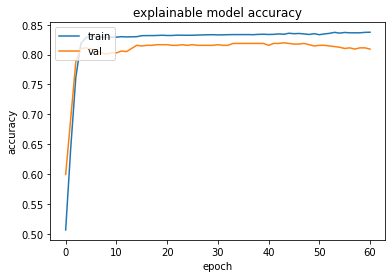

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

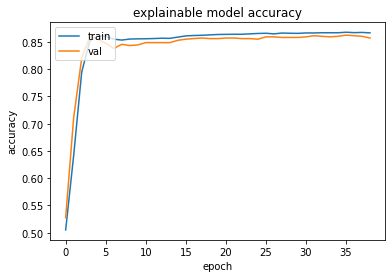

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

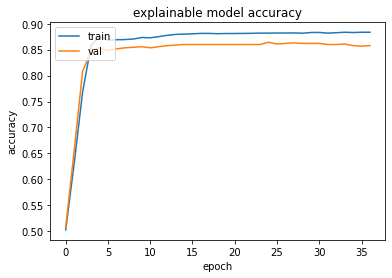

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

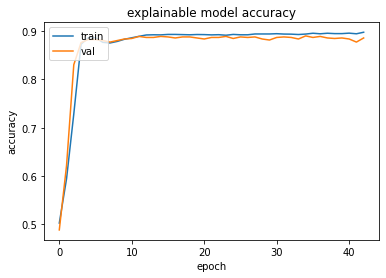

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

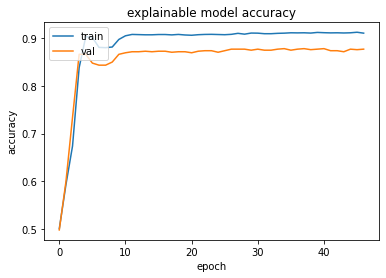

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

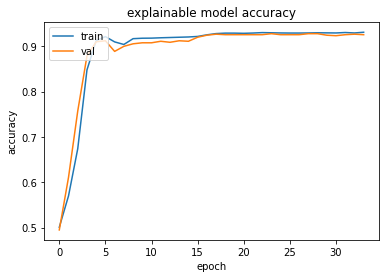

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

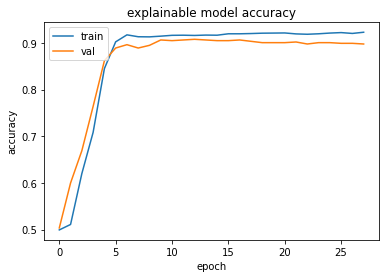

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

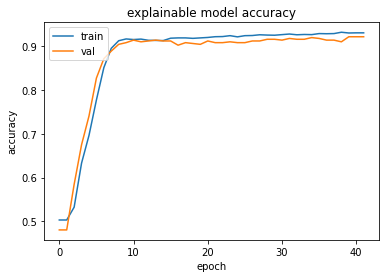

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

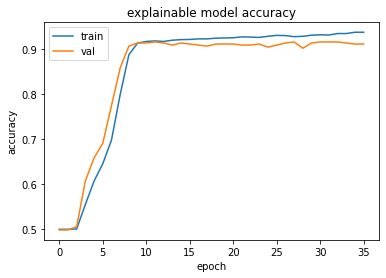

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

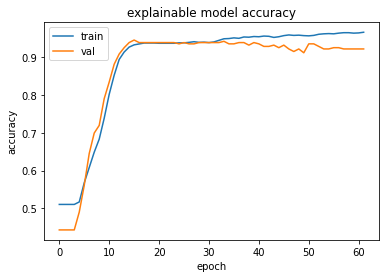

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

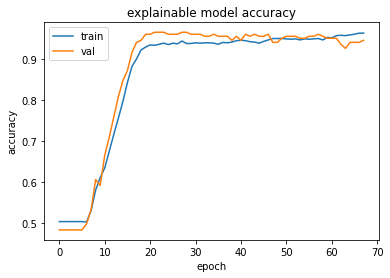

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

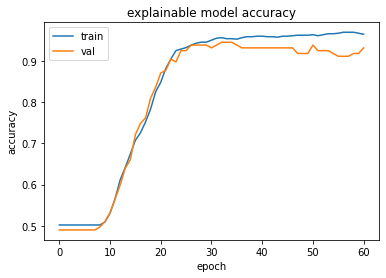

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

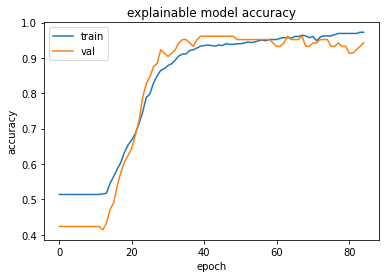

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

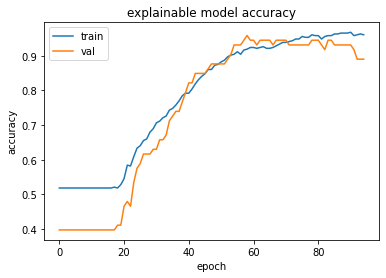

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

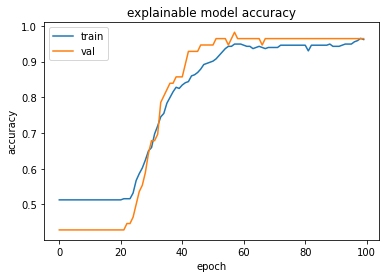

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

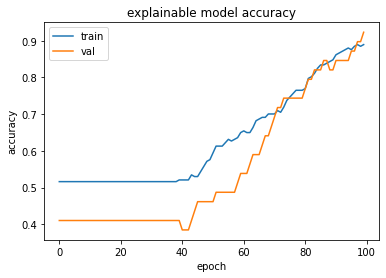

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........v

In [15]:
trained_models = []
hyperparametrs = []
trained_model_list = os.path.join(MILESTONE_DIR,'_model_list.pkl')

results_acc =[]
results_pre = []
results_rec = []
results_f1 = []
results_support = []

Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1','ROC_AUC','SUPPORT'])
df_explanations = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
df_predictions = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])

for i in range(len(buckets)):

  bucket = buckets[i]

  #Build Model
  max_len = full_vec[bucket]['vec_train']['prefixes'][activity_name].shape[1]
  exp_dim = inputs_outputs[bucket]['input_exp_dim']
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  opt = 'Adam' #'Nadam','Adamax','Adagrad'

  #model with hyperparameter tuning
  #self_explainable = self_explainable_model_optimum (input_train,output_train,indexes[bucket], args,exp_dim,opt, max_len)

  #model without hyperparameter tuning

  lstm_size_alpha = 70
  lstm_size_beta = 70
  dense_1_dim = 1.5
  learning_rate = 0.01

  self_explainable = self_explainable_model(args, max_len, input_train ,lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate ) #(indexes[bucket], args,exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, cat_dynamic, num_dynamic,cat_static,num_static,opt,max_len) 
  plot_model(
        self_explainable,
        to_file="self explainable model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )

  #Compile Model
  lambda_reg = 0.0001

  #Train Model
  batch_size = 256 # 32, 64, 128, 256
  epochs = 100
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  model_history = self_explainable_model_fit(input_train,output_train,args, self_explainable, MY_WORKSPACE_DIR, batch_size, epochs)
  plot_model_history(model_history) 

  output_file_path = os.path.join(MILESTONE_DIR,'_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(output_file_path, 'wb') as fp:
    pickle.dump(self_explainable, fp, protocol=pickle.HIGHEST_PROTOCOL)
  
  #add the saved model name to a list (for future reference)
  trained_models.append(output_file_path)
  hyperparametrs.append(self_explainable.get_config())

  #Testing the Model and saving the macro level results as a dataframe

  input_test = inputs_outputs[bucket]['inputs_test']
  output_test = inputs_outputs[bucket]['outputs_test']
  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  index_oc = indexes[bucket]['index_oc']

  report = test_model(input_test, output_test, exp_dim, features_exp,self_explainable,index_oc)
  #Generating Key outputs for explaining the model
  input_test, model_output_test, features_exp = model_outputs(input_test, output_test, exp_dim, features_exp,self_explainable)
  roc_auc = roc_auc_score(model_output_test['y_test'], model_output_test['y_pred'])

  Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'],
                                    'F-1': report['weighted avg']['f1-score'], 'ROC_AUC':roc_auc,'SUPPORT': report['weighted avg']['support']}, index = [i])
  Results_df = pd.concat([Results_df,Results_df_bucket])

  if bucket in ['1_5','1_10','1_15','1_20']:

    df_exp = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','LAST_LAYER_WEIGHTS','BUCKET'])
    df_pred = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])

    df_exp['CASEID'] = [case  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_exp'].shape[1])]
    df_exp['FEATURE'] = [feature for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for feature in features_exp ]
    df_exp['FEATURE_VALUE'] = input_test['input_exp'].flatten()
    df_exp['FEATURE_IMPORTANCE'] = model_output_test['y_test_exp'].flatten()
    df_exp['LAST_LAYER_WEIGHTS'] =  [weight for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for weight in self_explainable.get_layer('act_output').get_weights()[0].T[0] ]
    df_exp['BUCKET'] = [bucket  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_exp'].shape[1])]

    df_exp['FEATURE_IMPORTANCE'] = df_exp['FEATURE_IMPORTANCE']*df_exp['LAST_LAYER_WEIGHTS'] 
    df_exp = df_exp.drop(columns = 'LAST_LAYER_WEIGHTS')

    df_pred['CASEID'] = full_vec[bucket]['vec_test']['caseid']
    df_pred['PREDICTION_PROB'] = model_output_test['y_pred']
    df_pred['PREDICTION'] = [index_oc[int(pred>0.5)] for pred in model_output_test['y_pred'] ]
    df_pred['GROUND_TRUTH'] = [index_oc[test] for test in model_output_test['y_test'] ]
    df_pred['BUCKET'] = [bucket  for case in full_vec[bucket]['vec_test']['caseid'] ]


    df_explanations = pd.concat([df_explanations,df_exp])
    df_predictions = pd.concat([df_predictions,df_pred])

file_name_exp = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_explanations.csv')
df_explanations.to_csv(file_name_exp)

file_name_pred = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_predictions.csv')
df_predictions.to_csv(file_name_pred)

file_name_results = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_results.csv')
Results_df.to_csv(file_name_results)




##### Model Results

Total Runtime of all the models is ~ 45 minutes

In [16]:
Results_df

,BUCKET,ACCURACY,PRECISION,RECALL,F-1,ROC_AUC,SUPPORT
0,1_5,0.766126,0.881576,0.766126,0.790618,0.866255,3147
1,1_6,0.810871,0.892666,0.810871,0.829101,0.900930,3146
2,1_7,0.832697,0.901156,0.832697,0.848016,0.916519,3144
3,1_8,0.833493,0.902668,0.833493,0.848873,0.915143,3141
4,1_9,0.879745,0.917067,0.879745,0.888579,0.945066,3135
5,1_10,0.888229,0.923365,0.888229,0.896265,0.952593,3033
6,1_11,0.870817,0.923969,0.870817,0.883154,0.954049,2570
7,1_12,0.881671,0.926740,0.881671,0.893072,0.948738,2155
8,1_13,0.906689,0.936863,0.906689,0.914247,0.961466,1779
9,1_14,0.884615,0.931555,0.884615,0.897037,0.954834,1352


### Model Evaluation

#### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

LR_Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1', 'ROC_AUC', 'SUPPORT'])

LR_Explanations_df = pd.DataFrame (columns =  ['BUCKET','FEATURE','FEATURE_IMPORTANCE'] )


for i in range(len(buckets)):

  bucket = buckets[i]

  X_train = inputs_outputs[bucket]['inputs_train']['input_exp']
  y_train = inputs_outputs[bucket]['outputs_train']['act_output']

  X_test = inputs_outputs[bucket]['inputs_test']['input_exp']
  y_test = inputs_outputs[bucket]['outputs_test']['act_output']

  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  LR = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)

  LR_path = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_LR_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(LR_path, 'wb') as fp:
    pickle.dump(LR, fp, protocol=pickle.HIGHEST_PROTOCOL)

  index_oc = indexes[bucket]['index_oc']
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_pred= LR.predict(X_test)
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  roc_auc = roc_auc_score(y_test, y_pred)

  LR_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'], 
                                       'F-1': report['weighted avg']['f1-score'], 'ROC_AUC':roc_auc,'SUPPORT': report['weighted avg']['support']}, index = [i])

  
  LR_Results_df = pd.concat([LR_Results_df,LR_Results_df_bucket])

  LR_coef = LR.coef_[0].tolist()
  LR_prediction = [index_oc[1] for f in features_exp]
  try: LR_features = features_exp.tolist()
  except: LR_features = features_exp
  LR_exp_dict = {'BUCKET': bucket,'PREDICTION':LR_prediction, 'FEATURE': LR_features,'FEATURE_IMPORTANCE': LR_coef}

  LR_Explanations_df_bucket = pd.DataFrame(LR_exp_dict)
  LR_Explanations_df = pd.concat([LR_Explanations_df,LR_Explanations_df_bucket])

file_name_LR_results = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_LR_results.csv')
LR_Results_df.to_csv(file_name_LR_results)

file_name_LR_explanations = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_LR_explanations.csv')
LR_Explanations_df.to_csv(file_name_LR_explanations)








In [18]:
LR_Results_df

,BUCKET,ACCURACY,PRECISION,RECALL,F-1,ROC_AUC,SUPPORT
0,1_5,0.737528,0.879998,0.737528,0.765833,0.824634,3147
1,1_6,0.777177,0.891140,0.777177,0.800527,0.852969,3146
2,1_7,0.784669,0.894728,0.784669,0.807166,0.860224,3144
3,1_8,0.802292,0.897483,0.802292,0.822373,0.868536,3141
4,1_9,0.825837,0.906888,0.825837,0.842960,0.887731,3135
5,1_10,0.858886,0.915236,0.858886,0.871151,0.905086,3033
6,1_11,0.852918,0.920237,0.852918,0.868240,0.908085,2570
7,1_12,0.859397,0.923976,0.859397,0.875065,0.909622,2155
8,1_13,0.880270,0.929407,0.880270,0.892237,0.920300,1779
9,1_14,0.871302,0.932667,0.871302,0.886828,0.921034,1352


####Deep learning Non Explainable

In [19]:
#Deep learning baseline model

def deep_baseline_model (indexes, args, exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, cat_dynamic, num_dynamic,cat_static,num_static,opt = None, max_len = None):

  EXPERIMENT = args['experiment']
  prefix_len = args['prefix_length']

  if  max_len == None:
    MAX_LEN = args['n_size']
  else:
    MAX_LEN = max_len


  incl_time = True 
  incl_res = True
    
  dropout = 0.15
  #lstm_size_alpha =  hp.Int('units', min_value=32, max_value=512, step=32) #50
  l2reg=0.0001
  dropout_input = 0.15
  dropout_context=0.15

  dim_dynamic = 0
  for feat in cat_dynamic:
    dim_dynamic = dim_dynamic+len(indexes['dynamic_indexes'][feat+'_index'])
  dim_dynamic = dim_dynamic+len(num_dynamic)

  dim_static = 0
  for feat in cat_static:
    dim_static = dim_static+len(indexes['static_indexes'][feat+'_index'])
  dim_static = dim_static+len(num_static)
  

  #configuring the inputs

  raw_input = layers.Input(shape=(MAX_LEN,dim_dynamic, ), name='raw_input') #Raw input x
  #raw_input = layers.Dropout(dropout)(raw_input)

  raw_input_static = layers.Input(shape = (dim_static,), name = 'raw_input_static' ) #Static input x

  #input = layers.Input(shape=(exp_dim, ), name='exp_input') #explainable input h(x)
  #input = layers.Dropout(dropout,name='exp_input')(input)

  #LSTM layer with attention to process x

  alpha = layers.Bidirectional(layers.LSTM(lstm_size_alpha, return_sequences=True),
                                        name='alpha')
  alpha_dense = layers.Dense(1, kernel_regularizer=l2(l2reg))
  alpha_out = alpha(raw_input)
  alpha_out = layers.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)
  alpha_out = layers.Softmax(name='timestep_attention', axis=1)(alpha_out)

  #second LSTM layer with attention to process x - sequential
  
  beta = layers.Bidirectional(layers.LSTM(lstm_size_beta, return_sequences=True),
                                        name='beta')
  beta_dense = layers.Dense(dim_dynamic, activation='tanh', kernel_regularizer=l2(l2reg))
  beta_out = beta(raw_input)
  beta_out = layers.TimeDistributed(beta_dense, name='beta_dense')(beta_out)
  beta_out = layers.Softmax(name='beta_timestep_attention', axis=1)(beta_out)

  #Compute context vector based on attentions and raw input x
  c_t = layers.Multiply()([alpha_out, beta_out, raw_input])
  c_t = layers.Lambda(lambda x: backend.sum(x, axis=1))(c_t)
  c_t = layers.concatenate([c_t,raw_input_static],name = 'full_features')

  #contexts = layers.Dropout(dropout)(c_t)

  '''#Intermediate dense layer
  dense_1_dim = round(exp_dim*dense_1_dim) 

  dense_1 = layers.Dense(dense_1_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='dense_1')(contexts)

  #Dense layer to compute the explainable weights thetas

  thetas = layers.Dense(exp_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='explanation_weights')(dense_1)'''
 
  #initialize all the weights to one
  initializer = tf.keras.initializers.Ones()  
  act_output = layers.Dense(1,activation='sigmoid',kernel_initializer=initializer,trainable=True, name='act_output')(c_t)


  model = Model(inputs=[raw_input, raw_input_static], outputs=act_output)

  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer choice

  if opt == 'Adam':
    optim = keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'Nadam':
    optim = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adamax':
    optim = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adagrad':
    optim = keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=0.1, epsilon=1e-07)
  else:
     optim = keras.optimizers.Adam(learning_rate=learning_rate) 




  model.compile(loss={'act_output': 'binary_crossentropy'}, optimizer= optim , metrics=['accuracy']) 
  
  
  return model

#-----------------------------------------------------------------------------------------------------------------------------------------------
  #Training the model

def deep_baseline_model_fit(input_train,output_train,args, deep_baseline_model, MY_WORKSPACE_DIR, batch_size, epochs):


  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  output_file_path = os.path.join(os.path.join(MY_WORKSPACE_DIR,
                                        'models'),'model_' +args['prediction']+
                                        '_{epoch:02d}-{val_loss:.2f}.h5')
  
  lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=10,
                                    verbose=0,
                                    mode='auto',
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)
  
  

  model_history = deep_baseline_model.fit([input_train['input_dynamic'],input_train['input_static']], output_train['act_output'],
              validation_split=0.15,
              #validation_data=(model_val_inputs, model_val_outputs),
              verbose=1,
              callbacks=[early_stopping,lr_reducer],
              batch_size=batch_size,
              epochs=epochs)
  
  return model_history
   
#-----------------------------------------------------------------------------------------------------------------------------------------------
#Plot Model History
def plot_deep_baseline_model_history(history):
    #Training and validation curves

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('deep baseline model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


#-----------------------------------------------------------------------------------------------------------------------------------------------
#Model Testing
def test_deep_baseline_model(input_test, output_test, deep_baseline_model,index_oc):

  print("Evaluate on test data")
  results = deep_baseline_model.evaluate([input_test['input_dynamic'],input_test['input_static']], output_test['act_output'], batch_size=100)
  print("test loss, test acc:", results)
  print("\n")

  print("Classification Report")
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_test = output_test['act_output']
  y_out = deep_baseline_model.predict([input_test['input_dynamic'],input_test['input_static']])
  y_pred = y_out
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  print("\n")

  '''print("Confusion Matrix")
  matrix = confusion_matrix(y_test, y_pred_bin )

  matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
  matrix_perc = matrix / matrix_sum
  df_cm = pd.DataFrame(matrix_perc, index = target_names,
                  columns = target_names)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)'''

  return report

###### Model Execution

Epoch 1/100
11/11 [==============================] - 9s 139ms/step - loss: 0.8663 - accuracy: 0.6170 - val_loss: 0.7247 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 0s 12ms/step - loss: 0.6802 - accuracy: 0.6716 - val_loss: 0.6114 - val_accuracy: 0.6846 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5771 - accuracy: 0.6940 - val_loss: 0.5399 - val_accuracy: 0.6994 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5153 - accuracy: 0.7177 - val_loss: 0.4910 - val_accuracy: 0.7152 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4612 - accuracy: 0.7507 - val_loss: 0.4469 - val_accuracy: 0.7521 - lr: 0.0100
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4290 - accuracy: 0.7807 - val_loss: 0.4268 - val_accuracy: 0.7774 - lr: 0.0100
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - l

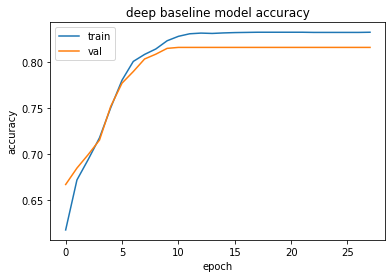

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

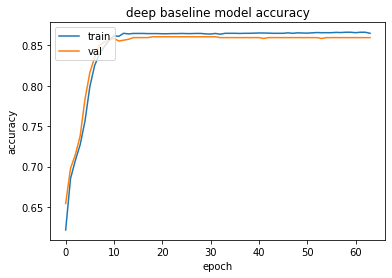

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

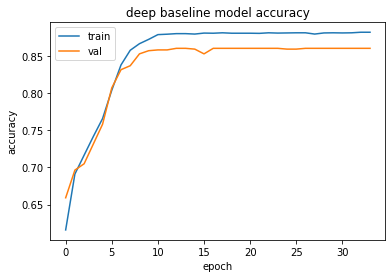

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

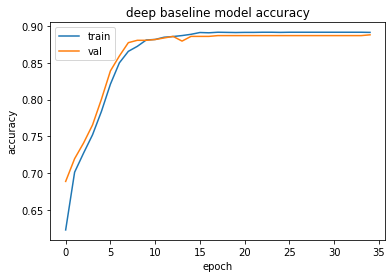

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

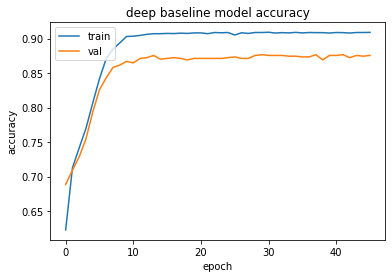

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

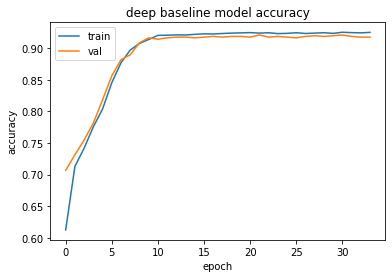

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

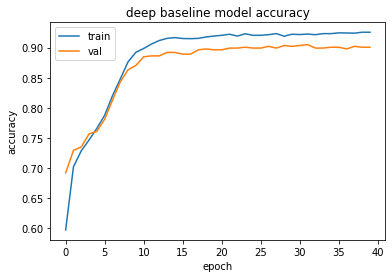

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

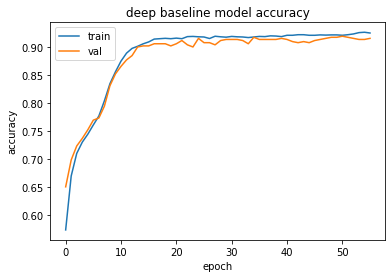

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

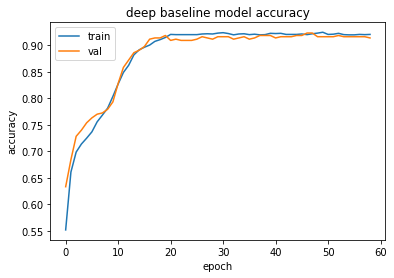

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

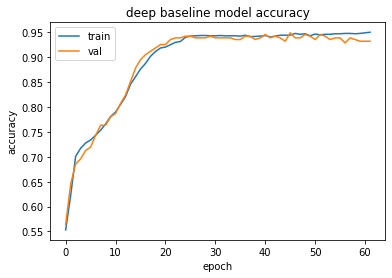

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

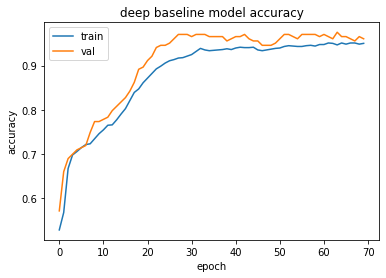

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

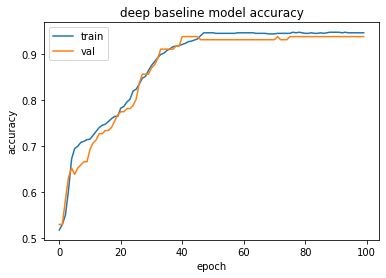

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

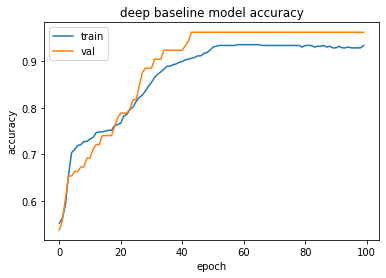

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

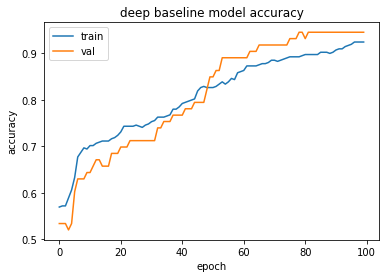

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

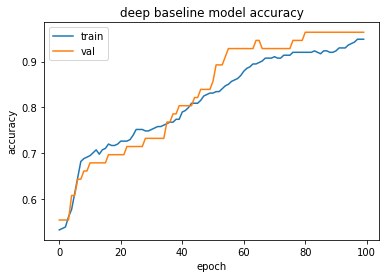

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

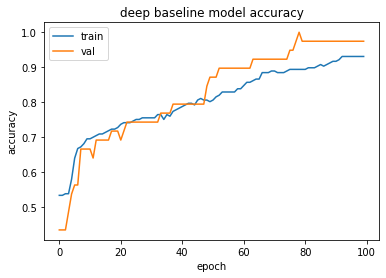

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.

In [20]:
trained_models = []
trained_model_list = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_model_list.pkl')

results_acc =[]
results_pre = []
results_rec = []
results_f1 = []
results_support = []

DL_Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1', 'SUPPORT'])
DL_df_explanations = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
DL_df_predictions = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])


for i in range(len(buckets)):

  bucket = buckets[i]

  #Build Model
  max_len = full_vec[bucket]['vec_train']['prefixes'][activity_name].shape[1]
  exp_dim = inputs_outputs[bucket]['input_exp_dim']
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  opt = 'Adam' #'Nadam','Adamax','Adagrad'

  #model with hyperparameter tuning
  #self_explainable = self_explainable_model_optimum (input_train,output_train,indexes[bucket], args,exp_dim,opt, max_len)

  #model without hyperparameter tuning

  lstm_size_alpha = 70 #hyperparametrs[i]['layers'][1]['config']['layer']['config']['units']
  lstm_size_beta = 70 #hyperparametrs[i]['layers'][3]['config']['layer']['config']['units']
  dense_1_dim = 1.5
  learning_rate = 0.01

  deep_baseline = deep_baseline_model(indexes[bucket], args,exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, cat_dynamic, num_dynamic,cat_static,num_static,opt,max_len) 
  plot_model(
        deep_baseline,
        to_file="deep_baseline_model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )

  #Compile Model
  lambda_reg = 0.0001

  #Train Model
  batch_size = 512 # 32, 64, 128, 256
  epochs = 100
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  model_history = deep_baseline_model_fit(input_train,output_train,args, deep_baseline, MY_WORKSPACE_DIR, batch_size, epochs)
  plot_deep_baseline_model_history(model_history) 

  output_file_path = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_DL_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(output_file_path, 'wb') as fp:
    pickle.dump(deep_baseline, fp, protocol=pickle.HIGHEST_PROTOCOL)
  
  #add the saved model name to a list (for future reference)
  trained_models.append(output_file_path)

  #Testing the Model and saving the macro level results as a dataframe

  input_test = inputs_outputs[bucket]['inputs_test']
  output_test = inputs_outputs[bucket]['outputs_test']
  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  index_oc = indexes[bucket]['index_oc']
  report = test_deep_baseline_model(input_test, output_test, deep_baseline,index_oc)

  DL_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'], 'F-1': report['weighted avg']['f1-score'], 'SUPPORT': report['weighted avg']['support']}, index = [i])
  

  #Get the attention weights from the model

  model_attn_weights = Model(inputs=deep_baseline.input,
              outputs=[deep_baseline.output, deep_baseline.get_layer('timestep_attention').output,deep_baseline.get_layer('beta_timestep_attention').output])

  output_with_attention = model_attn_weights.predict([input_test['input_dynamic'],input_test['input_static']])


  #Predictions
  y_pred = output_with_attention[0]
  y_pred = [pred[0] for pred in y_pred ]
  roc_auc = roc_auc_score(full_vec[bucket]['vec_test']['outcome'], y_pred)
  DL_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],
                                       'RECALL': report['weighted avg']['recall'], 
                                       'F-1': report['weighted avg']['f1-score'], 'ROC_AUC': roc_auc, 'SUPPORT': report['weighted avg']['support']}, index = [i])
  DL_Results_df = pd.concat([DL_Results_df,DL_Results_df_bucket])

  #Feature Importance
  feat_importance = output_with_attention[1]*output_with_attention[2]

  #Feature Names
  feature_names = []
  ac_names =  [item[0] for item in indexes[bucket]['dynamic_indexes']['ACTIVITY_index'].items()]
  feature_names.extend(ac_names)
  role_names = [item[0] for item in indexes[bucket]['dynamic_indexes']['ROLE_index'].items()]
  feature_names.extend(role_names)
  feature_names.extend(num_dynamic)
  features_raw = [item+' at event '+str(input_test['input_dynamic'].shape[1]-i) for i in range(input_test['input_dynamic'].shape[1]) for item in feature_names] 
  features_raw = np.asarray(features_raw)
  
  if bucket in ['1_5','1_10','1_15','1_20']:

    #df_pred
    df_pred = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])
    df_pred['CASEID'] = full_vec[bucket]['vec_test']['caseid']
    df_pred['PREDICTION_PROB'] = y_pred
    df_pred['PREDICTION'] = [index_oc[int(pred>0.5)] for pred in y_pred ]
    df_pred['GROUND_TRUTH'] = [index_oc[test] for test in full_vec[bucket]['vec_test']['outcome'] ]
    df_pred['BUCKET'] = bucket

    #df_exp
    df_exp = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
    df_exp['CASEID'] = [case  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_dynamic'].shape[1]*input_test['input_dynamic'].shape[2])]
    df_exp['FEATURE'] = [feature for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for feature in features_raw ]
    df_exp['FEATURE_VALUE'] = input_test['input_dynamic'].flatten()
    df_exp['FEATURE_IMPORTANCE'] = feat_importance.flatten()
    df_exp['BUCKET'] = bucket

    DL_df_explanations = pd.concat([DL_df_explanations,df_exp])
    DL_df_predictions = pd.concat([DL_df_predictions,df_pred])


file_name_exp = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_explanations.csv')
DL_df_explanations.to_csv(file_name_exp)

file_name_pred = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_predictions.csv')
DL_df_predictions.to_csv(file_name_pred)

file_name_results = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_results.csv')
DL_Results_df.to_csv(file_name_results)


In [21]:
DL_Results_df

,BUCKET,ACCURACY,PRECISION,RECALL,F-1,SUPPORT,ROC_AUC
0,1_5,0.763267,0.882674,0.763267,0.788215,3147,0.869733
1,1_6,0.812778,0.894763,0.812778,0.830854,3146,0.902710
2,1_7,0.827926,0.899689,0.827926,0.843926,3144,0.915217
3,1_8,0.842089,0.904660,0.842089,0.856179,3141,0.917412
4,1_9,0.879745,0.918920,0.879745,0.888798,3135,0.945644
5,1_10,0.900099,0.927758,0.900099,0.906560,3033,0.959776
6,1_11,0.875875,0.924006,0.875875,0.887252,2570,0.954278
7,1_12,0.880278,0.927247,0.880278,0.892035,2155,0.953868
8,1_13,0.896571,0.934512,0.896571,0.905867,1779,0.965756
9,1_14,0.894970,0.937235,0.894970,0.905866,1352,0.964232
